In [ ]:
!pip install scikit-learn

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset with error handling
try:
    df = pd.read_csv('data_for_models.csv')
except FileNotFoundError:
    print("The specified file was not found.")

<ipython-input-6-a3e7eecd5df7>:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_for_models.csv')


In [ ]:
# Separate features and target variable
X = df.drop(['order_code', 'display_name'], axis=1)
y = df['display_name']

# Split dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

# Select categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [ ]:
# Define the model pipeline with the best parameters found
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        max_depth=None,
        random_state=42,
        class_weight='balanced_subsample'))
])

# Train the model using the training data
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'qty_items_sold_item_1', 'weight_item_1', 'volume_item_1',
       'height_item_1', 'qty_items_sold_item_2', 'weight_item_2',
       'volume_item_2', 'height_item_2', 'qty_items_sold_item_3',
       'weight_item_3', 'v...
       'sap_main_size_item_13', 'product_navision_detail_category_item_13',
       'label_item_13', 'sap_main_size_item_14',
       'product_navision_detail_category_item_14', 'label_item_14',
       'sap_main_size_item_15', 'product_navision_detail_category_item_15',
       'label_item_15'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=300, random_state=42))])


Classification Report:
               precision    recall  f1-score   support

        BS 1       0.73      0.48      0.58      8298
        BS 2       0.41      0.26      0.31      4090
        BS 3       0.45      0.60      0.51      2911
        BS 4       0.48      0.50      0.49      1973
        BS 5       0.12      0.33      0.17        30
        BS 6       0.56      0.68      0.61       292
        BS 8       0.49      0.70      0.57      1747
     BS Mini       0.57      0.76      0.65      2836
        Groß       0.55      0.60      0.58      5126
       Klein       0.61      0.77      0.68      3747
    Original       0.40      0.33      0.36         6

    accuracy                           0.56     31056
   macro avg       0.49      0.55      0.50     31056
weighted avg       0.57      0.56      0.55     31056

Accuracy: 0.5582496136012365
F1 Score: 0.5504332116941365


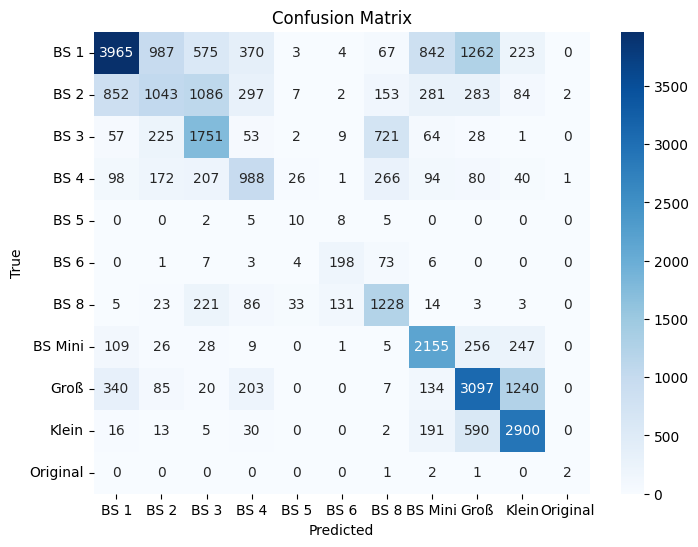


Top 10 Feature Importances:
                      Feature  Importance
2              weight_item_1    0.055669
3              volume_item_1    0.047284
6              weight_item_2    0.034246
7              volume_item_2    0.025040
10             weight_item_3    0.024794
487  sap_main_size_item_1_OS    0.022685
0                 Unnamed: 0    0.019514
11             volume_item_3    0.016678
14             weight_item_4    0.015858
18             weight_item_5    0.013485


<ipython-input-10-21888bd88279>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-10-21888bd88279>:36: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


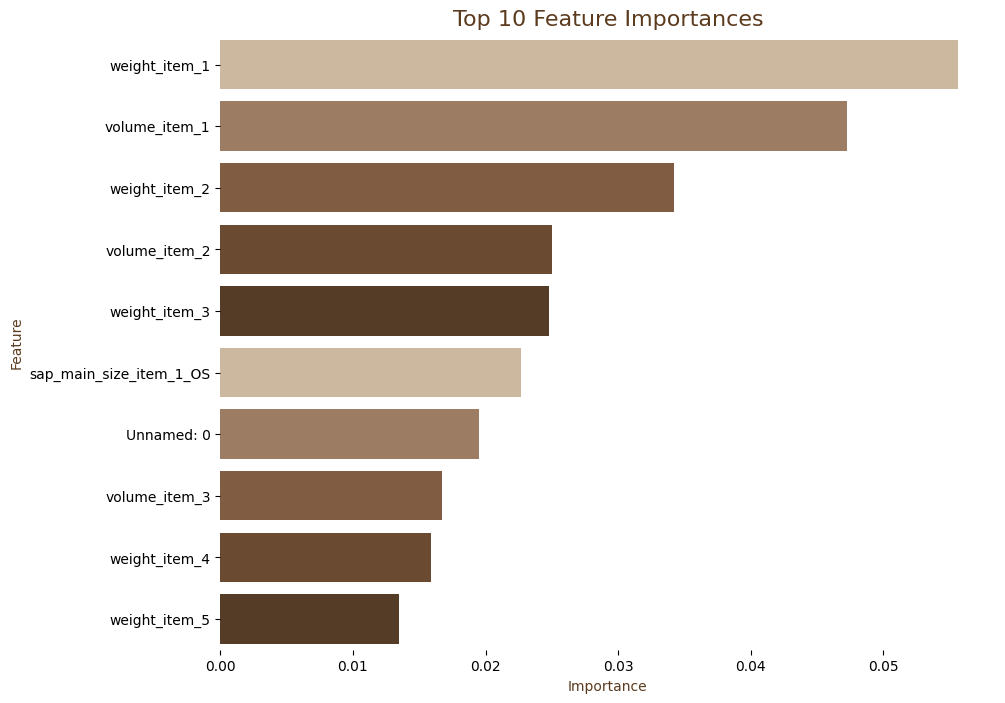

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Print classification report with target names
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=model.classes_))

# Print accuracy and F1 Score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
if isinstance(model.named_steps['classifier'], RandomForestClassifier):
    feature_importances = model.named_steps['classifier'].feature_importances_
    feature_names = numerical_cols.tolist() + list(model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols))
    feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

    # Display feature importances
    print("\nTop 10 Feature Importances:\n", feature_importances_df.head(10))

    # Plot feature importances with cream-brown color scheme and transparent background
    plt.figure(figsize=(10, 8), facecolor="none")  # Transparent background
    sns.barplot(
        x='Importance', y='Feature', data=feature_importances_df.head(10),
        palette=sns.color_palette(["#D4B996", "#A67B5B", "#8A5B38", "#734A29", "#5C3B1F"])  # Cream-brown colors
    )

    # Customize the appearance
    ax = plt.gca()
    ax.set_facecolor("none")  # Transparent axis background
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.xlabel('Importance', color="#5C3B1F")
    plt.ylabel('Feature', color="#5C3B1F")
    plt.title('Top 10 Feature Importances', color="#5C3B1F", fontsize=16)
    plt.grid(visible=False)
    plt.show()